In [23]:
%pylab --n
%matplotlib inline
import seaborn as sns
import birdsonganalysis as bsa
from scipy.io import wavfile
from IPython.display import Audio, display

sns.set_palette('colorblind')

import sys

sys.path.append('../model/')
from song_model import SongModel
from gesture_fitter import fit_gesture_padded, fit_gesture_whole
from measures import bsa_measure
from synth import synthesize

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [30]:
sr, ts = wavfile.read('../data/ba_example.wav')
sm = SongModel(song=ts, priors=np.zeros(18))

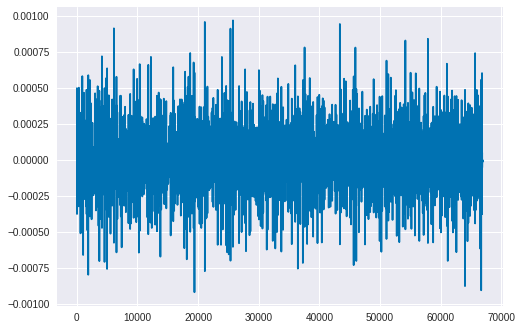

In [22]:
plt.plot(sm.gen_sound(fixed_normalize=True))

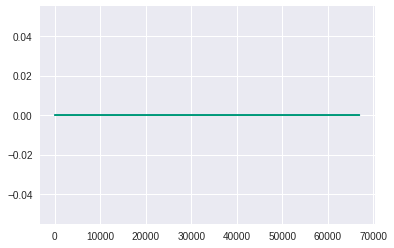

In [48]:
plt.plot(sm.gen_alphabeta())

In [81]:
ab = np.loadtxt('../data/ba_example_ab.dat')

In [82]:
synth_whole = synthesize(ab, fixed_normalize=True)

In [114]:
beg = 19025
end = 25000

In [115]:
synth_part = synthesize(ab[beg:end+2], fixed_normalize=True)

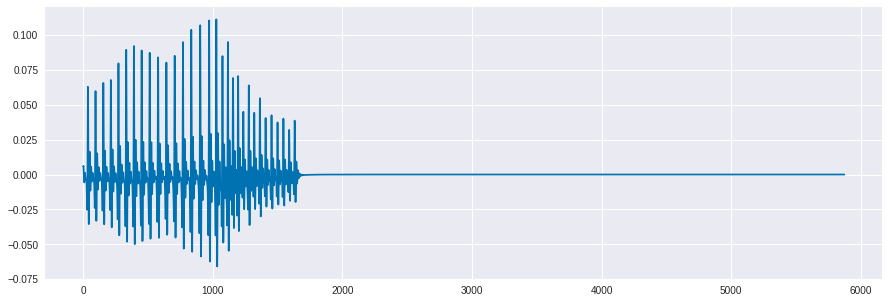

In [118]:
plt.figure(figsize=(15, 5))
plt.plot(synth_whole[beg+100:end])

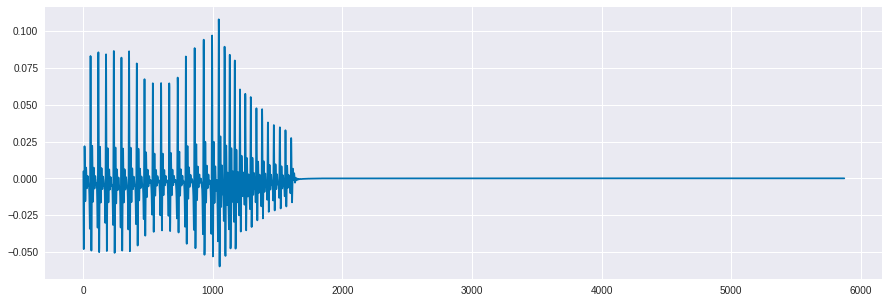

In [119]:
plt.figure(figsize=(15, 5))
plt.plot(synth_part[100:])

In [95]:
Audio(data=synth_part, rate=44100)

In [96]:
part_feat = bsa.all_song_features(synth_part, 44100)
whole_feat = bsa.all_song_features(synth_whole, 44100)

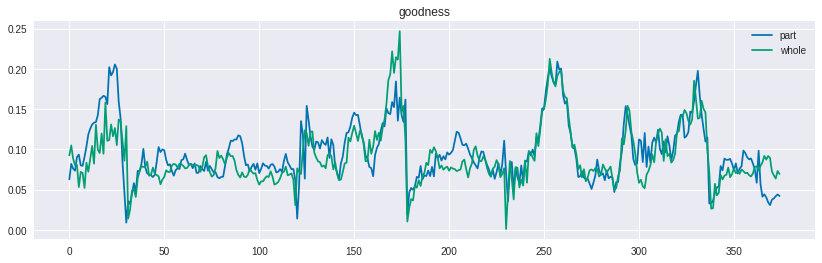

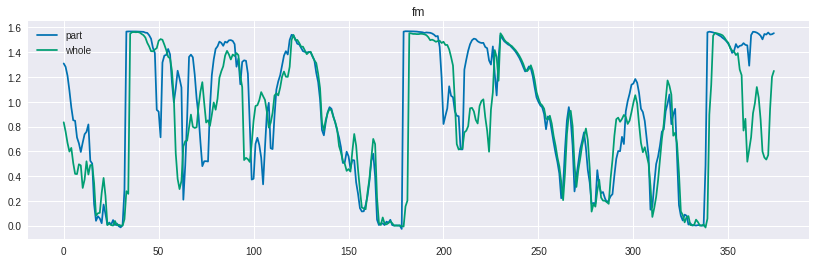

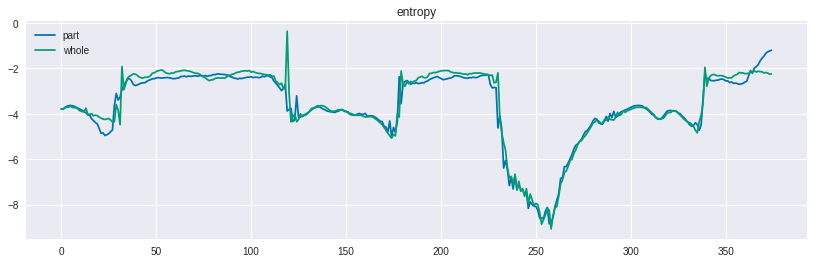

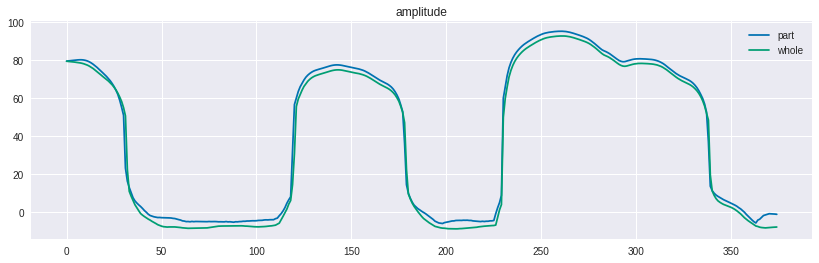

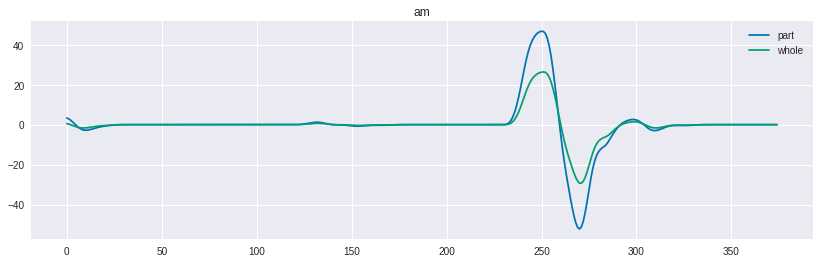

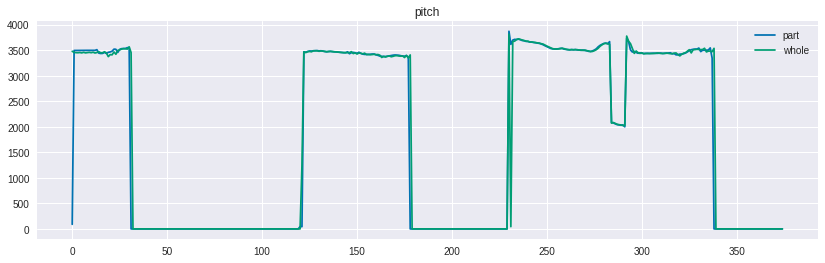

In [97]:
for nfeat in part_feat:
    plt.figure(figsize=(14, 4))
    plt.plot(part_feat[nfeat], label="part")
    plt.plot(whole_feat[nfeat][beg//40:end//40], label="whole")
    plt.legend()
    plt.title(nfeat)
    plt.show()